# Automating Data Preprocessing of Agent Calls Data

In [ ]:
!pip install xlsxwriter

In [1]:
# importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

In [6]:
# -- global variables
resources_folder = 'resources'
results_folder = 'results'
data_file = os.path.join(resources_folder, 'agent_level_calls.xlsx')
aggregation = 'Weekday'  # options: 'Month', 'Week', 'Weekday', 'Hour', None
output_file = os.path.join(results_folder, f'cleaned_agent_calls_by_{aggregation}.xlsx')

## Data Preparation

In [7]:
start_time = time.time()
# ---- DATA LOADING
print('Loading dataset ...')
df = pd.read_excel(data_file)
print(f'  Dataset loaded. Shape of dataset is {df.shape} \n')

# ---- DATA CLEANING

print("Cleaning dataset ...")
# combine date & time as a single column and correct the dtype
df['Date-Time'] = df['Date'].astype('str') + " " + df['Time'].astype('str')
df['Date-Time'] = pd.to_datetime(df['Date-Time'])

# convert formatting to seconds
df['AvgTalkDuration'] = pd.to_timedelta(df['AvgTalkDuration'].astype('str')).dt.total_seconds()

# sort data according to date
df.sort_values(by='Date-Time', inplace=True)

# impute missing/NaN values
df['Speed of answer in seconds'] = df['Speed of answer in seconds'].fillna(0)
df['AvgTalkDuration'] = df['AvgTalkDuration'].fillna(0)

# reconstruct answered calls to compute for answer rate
df['Answered'] = [1 if df.loc[i, 'Answered (Y/N)'] == "Y" else 0 for i in range(len(df))]
df['Not Answered'] = [1 if df.loc[i, 'Answered (Y/N)'] == "N" else 0 for i in range(len(df))]

# reconstruct resolved calls to compute for resolution rate
df['Resolved (Y/N)'] = df['Resolved']
df['Resolved'] = [1 if df.loc[i, 'Resolved (Y/N)'] == "Y" else 0 for i in range(len(df))]
df['Not Resolved'] = [1 if df.loc[i, 'Resolved (Y/N)'] == "N" else 0 for i in range(len(df))]

# creating time fields
df['Hour'] = df['Date-Time'].dt.strftime('%H').astype(int)
df['Weekday'] = df['Date-Time'].dt.strftime('%a')
df['Week'] = df['Date-Time'].dt.strftime('%U').astype(int) + 1  # sunday as first day of week
df['Month'] = df['Date-Time'].dt.strftime('%b')

# remove unnecessary columns and rearrange kept ones
df = df.loc[:, ['Agent', 'Hour', 'Weekday', 'Week', 'Month',
                'Topic', 'Answered', 'Not Answered', 'Resolved', 'Not Resolved',
                'Speed of answer in seconds', 'AvgTalkDuration', 'Satisfaction rating']]

# create metrics column
metrics = df.columns[6:]
print("  Dataset cleaned. \n")

# ----- DATA AGGREGATION
print("Aggregating dataset ...")
if aggregation:
    pivot_index = ['Agent', aggregation]
else:
    pivot_index = 'Agent'

df_pivot = df.pivot_table(
    index=pivot_index,
    values=metrics,
    aggfunc={
        'Answered': 'sum',
        'Not Answered': 'sum',
        'Resolved': 'sum',
        'Not Resolved': 'sum',
        'AvgTalkDuration': 'mean',
        'Speed of answer in seconds': 'mean',
        'Satisfaction rating': 'mean'
    }
)
print("  Aggregation complete. \n")

# ---- DATA EXPORT
print("Exporting cleaned and aggregated dataset ... ")
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    df_pivot.to_excel(writer, sheet_name='Pivot', index=True)
print("  Cleaned and aggregated dataset has been exported. \n")

print(f'Total execution time: {time.time() - start_time: 0.4f} seconds')

Loading dataset ...
  Dataset loaded. Shape of dataset is (5000, 10) 

Cleaning dataset ...
  Dataset cleaned. 

Aggregating dataset ...
  Aggregation complete. 

Exporting cleaned and aggregated dataset ... 
  Cleaned and aggregated dataset has been exported. 

Total execution time:  0.9839 seconds


## Chart Generation

Recurring questions we'd like to answer:
1. What topic is usually the concern for the call? Which of these topics is usually unresolved?
2. Is there a specific time window where more calls are being unanswered/unresolved? Does satisfaction drop during these time?
3. What contributes to higher satisfaction?

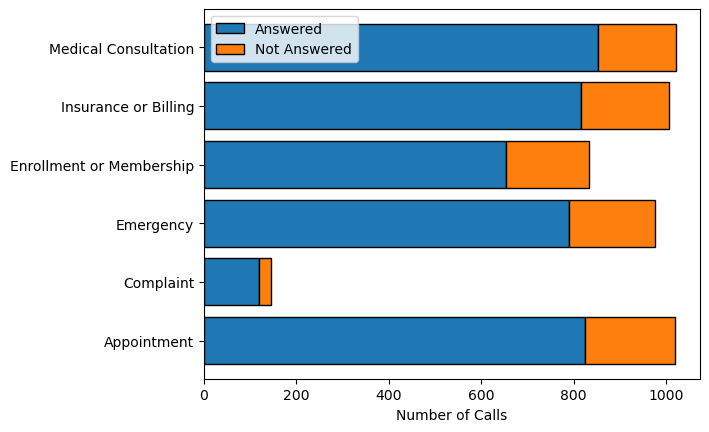

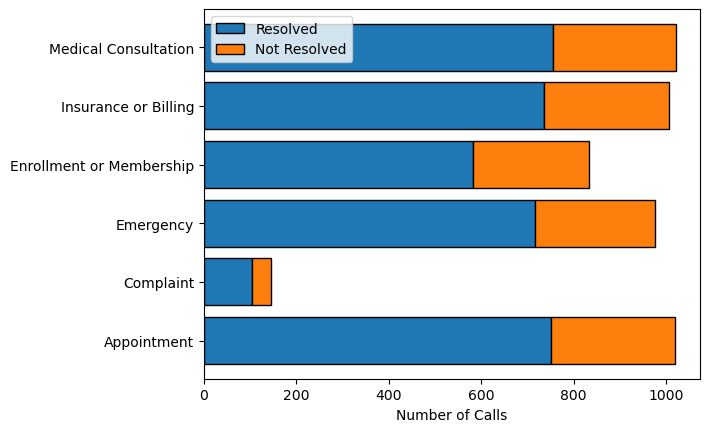

In [5]:
# create pivot
df_topic = df.pivot_table(
    index='Topic',
    values=metrics,
    aggfunc={
        'Answered': 'sum',
        'Not Answered': 'sum',
        'Resolved': 'sum',
        'Not Resolved': 'sum',
        'AvgTalkDuration': 'mean',
        'Speed of answer in seconds': 'mean',
        'Satisfaction rating': 'mean'
    }
)

# answered vs not
df_topic.plot(kind='barh', y=['Answered', 'Not Answered'], stacked=True, width=0.8, edgecolor='black', legend=True)

plt.ylabel('')
plt.xlabel('Number of Calls')
plt.legend(loc='best')
plt.savefig(os.path.join(results_folder, 'answered_calls_by_topic.png'), dpi=300)
plt.show()

# resolved vs not
df_topic.plot(kind='barh', y=['Resolved', 'Not Resolved'], stacked=True, width=0.8, edgecolor='black', legend=True)

plt.ylabel('')
plt.xlabel('Number of Calls')
plt.savefig(os.path.join(results_folder, 'resolved_calls_by_topic.png'), dpi=300)
plt.show()

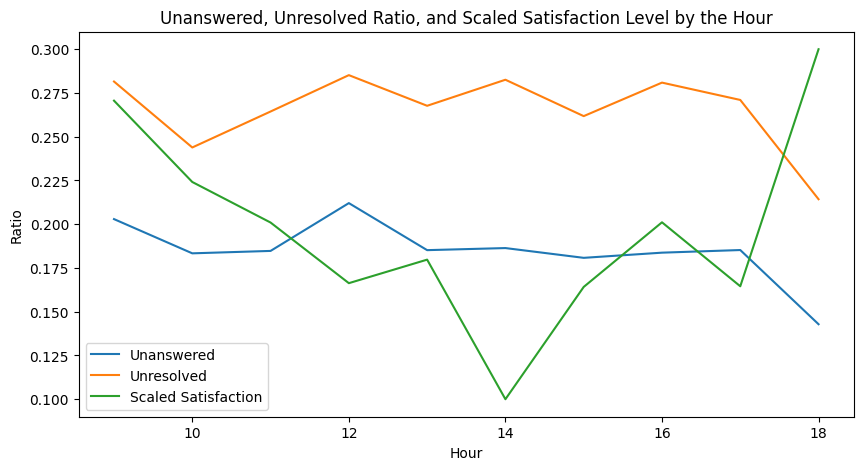

In [23]:
df_hour = df.pivot_table(
    index='Hour',
    values=metrics,
    aggfunc={
        'Answered': 'sum',
        'Not Answered': 'sum',
        'Resolved': 'sum',
        'Not Resolved': 'sum',
        'AvgTalkDuration': 'mean',
        'Speed of answer in seconds': 'mean',
        'Satisfaction rating': 'mean'
    }
)

df_hour['Unanswer Ratio'] = df_hour['Not Answered'] / (df_hour['Answered'] + df_hour['Not Answered'])
df_hour['Unresolved Ratio'] = df_hour['Not Resolved'] / (df_hour['Resolved'] + df_hour['Not Resolved'])


fig = plt.figure(figsize=(10,5))

df_hour['Scaled Satisfaction rating'] = 0.1 + ((df_hour['Satisfaction rating'] - df_hour['Satisfaction rating'].min()) * (0.3-0.1)) / (df_hour['Satisfaction rating'].max() - df_hour['Satisfaction rating'].min())

plt.plot(df_hour.index, df_hour['Unanswer Ratio'], label='Unanswered')
plt.plot(df_hour.index, df_hour['Unresolved Ratio'], label='Unresolved')
plt.plot(df_hour.index, df_hour['Scaled Satisfaction rating'], label='Scaled Satisfaction')

plt.xlabel('Hour')
plt.ylabel('Ratio')
plt.title('Unanswered, Unresolved Ratio, and Scaled Satisfaction Level by the Hour')
plt.legend()
plt.savefig(os.path.join(results_folder, 'unanswered_unresolved_satisfaction_by_hour.png'), dpi=300)
plt.show()